In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

In [3]:
# clean

df = pd.read_csv("nasa_adc_2025.csv")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12978 entries, 0 to 12977
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   MISSION ELAPSED TIME (min)  12978 non-null  float64
 1   Rx(km)[J2000-EARTH]         12978 non-null  float64
 2   Ry(km)[J2000-EARTH]         12978 non-null  float64
 3   Rz(km)[J2000-EARTH]         12978 non-null  float64
 4   Vx(km/s)[J2000-EARTH]       12978 non-null  float64
 5   Vy(km/s)[J2000-EARTH]       12978 non-null  float64
 6   Vz(km/s)[J2000-EARTH]       12978 non-null  float64
 7   MASS (kg)                   12978 non-null  float64
 8   WPSA                        12978 non-null  int64  
 9   WPSA Range                  5691 non-null   float64
 10  DS54                        12978 non-null  int64  
 11  DS54 Range                  4784 non-null   float64
 12  DS24                        12978 non-null  int64  
 13  Range DS24                  526

TypeError: cannot concatenate object of type '<class 'set'>'; only Series and DataFrame objs are valid

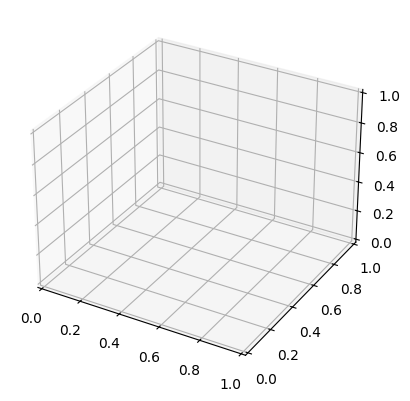

In [ ]:
# 3d test

# df = df.rename(columns={"Rz(km)[J2000-EARTH]":"range_z","Ry(km)[J2000-EARTH]":"range_y","Rx(km)[J2000-EARTH]":"range_x"})

def decision(row):
    if row["WPSA"]:
        return "red"
    elif row["DS54"]:
        return "green"
    elif row["DS54"]:
        return "blue"
    elif row["DS54"]:
        return "pink"
    else:
        return "black"

fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection="3d")

antenna_connection = pd.DataFrame(columns=['x', 'y', 'z','color'])

for i,n in df.iterrows():
    row = pd.DataFrame({{n["Rx(km)[J2000-EARTH]"],n["Ry(km)[J2000-EARTH]"],n["Rz(km)[J2000-EARTH]"],decision(n)}})
    antenna_connection = pd.concat([antenna_connection,row],ignore_index=True)

ax.scatter(antenna_connection['x'],antenna_connection["y"],antenna_connection["z"],color=antenna_connection['color'],marker="o")

z = df["Rz(km)[J2000-EARTH]"]
y = df["Ry(km)[J2000-EARTH]"]
x = df["Rx(km)[J2000-EARTH]"]


ax.plot(x,y,z, color="orange", linestyle="--")
ax.set_xlabel("x-axis")
ax.set_ylabel("y-axis")
ax.set_zlabel("z-axis")
ax.set_title("test plot 3d")

# ax.view_init(elev=-60,azim=90)
plt.show()
